# Project - Windspeed Analysis

Author: Céaman Collins

Wind power accounted for 35% of the total power generation in 2023, according to [Wikipedia](https://en.wikipedia.org/wiki/Wind_power_in_Ireland). Identifying suitable locations for wind farms remains one of the main challenges in further developing Ireland's already strong and growing wind power capacity. 

This project investigates the site at Mace Head Atmospheric Research Station, Carna, Co. Galway and estimates its potential for wind power generation. Its rich history and extensive record keeping makes it an ideal source of information for this analysis. In this analysis, we will:

* Use available data to look at extreme weather events and identify patterns
* Evaluate wind turbine operational viability at this location
* Compare Mace Head against other weather stations around Ireland
* Forecast future wind speeds using machine learning
* Estimate potential energy generation

![Mace Head](images/Location-of-the-Mace-Head-research-station-on-the-west-coast-of-Ireland.png)
[Source](https://www.researchgate.net/figure/Location-of-the-Mace-Head-research-station-on-the-west-coast-of-Ireland_fig1_307715793)



## Importing Packages

The first step as with most projects is to import the packages that will be used in the investigation.

In [1]:
from math import sqrt
from math import cos
import datetime as dt
import itertools
import warnings
import os

import regex as re
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
import openmeteo_requests
import requests_cache
from retry_requests import retry

## Importing Data

The next step is to import the data ensuring to parse the dates properly.

In [2]:
url = 'https://cli.fusio.net/cli/climate_data/webdata/hly275.csv'
mace_head = pd.read_csv(
    url, parse_dates=['date'], index_col='date', skiprows=17,
    low_memory=False, date_format='%d-%b-%Y %H:%M'
    )

Let's have a look at our data frame.

In [3]:
mace_head.head()

ind rain  ind.1 temp  ind.2 wetb dewpt vappr rhum msl  \
date                                                                         
2003-08-13 01:00:00   -1           4           4                             
2003-08-13 02:00:00   -1           4           4                             
2003-08-13 03:00:00   -1           4           4                             
2003-08-13 04:00:00   -1           4           4                             
2003-08-13 05:00:00   -1           4           4                             

                     ind.3 wdsp  ind.4 wddir  
date                                          
2003-08-13 01:00:00      7           7        
2003-08-13 02:00:00      7           7        
2003-08-13 03:00:00      7           7        
2003-08-13 04:00:00      7           7        
2003-08-13 05:00:00      7           7

## Cleaning the Data

There seem to be some empty values in the data set. We can replace these space characters with `NaN` objects, extract the features we are interested in and drop any rows that are missing values.

Wind direction becomes relevant in later analysis, and so it is extracted at this stage.

In [4]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
mace_head.replace(to_replace=' ', value=np.nan, inplace=True)
wind_speed = mace_head.loc[:, ['wdsp', 'wddir']].astype('Int64')
wind_speed.dropna(inplace=True)
wind_speed.head()

wdsp  wddir
date                            
2003-08-14 01:00:00     6     70
2003-08-14 02:00:00     4     80
2003-08-14 03:00:00     3     60
2003-08-14 04:00:00     5     70
2003-08-14 05:00:00     6     80

In [5]:
removed = (mace_head.shape[0] - wind_speed.shape[0]) / mace_head.shape[0]
retained = 1 - removed
print('Data Cleaning Summary:')
print('----------------------')
print(f'{int(removed * mace_head.shape[0])} data points removed due to missing values.')
print(f'{removed:.2%} of total data points were removed due to missing values.')
print(f'{retained:.2%} of total data points were retained after cleaning.')
years = (wind_speed.index.max() - wind_speed.index.min()).days / 365.25
print(f'{years:.2f} years of data available.')
print(f'{wind_speed.shape[0]} data points available after cleaning.')

Data Cleaning Summary:
----------------------
1307 data points removed due to missing values.
0.67% of total data points were removed due to missing values.
99.33% of total data points were retained after cleaning.
22.38 years of data available.
194941 data points available after cleaning.


1307 data points were removed as a result of the cleaning. While this may sound a lot, it was less than 1% of the total observed points, meaning the integrity of the data is extremely good. The data spans over 22 years with hourly resolution, totalling nearly 200,000 data points. This dataset is ideal for analysis and modelling.

## Investigating Storms

In order to further assess the station's capacity for measuring data, we can investigate particular extreme events that the station has captured.

According to the [Wikipedia](https://www.researchgate.net/figure/Location-of-the-Mace-Head-research-station-on-the-west-coast-of-Ireland_fig1_307715793) page for the weather station, many incredible storms have been recorded by this station.

* Storm Ali, 19th September, 2018
* Storm Callum, 12th and 13th October, 2018
* Storm Fionn, 16th January, 2019
* Storm Erik, 8th and 9th of February, 2019
* Storm Jake, 2nd March, 2016
* Storm Éoywn, 24th January, 2025

Let's see if we can find these recordings in the data.

The following sources helped me to annotate the graphs.

- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html
- https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyArrowPatch.html#matplotlib.patches.FancyArrowPatch
- https://stackoverflow.com/questions/17086847/box-around-text-in-matplotlib

I will create a script that will plot the appropriate graphs given relevant inputs.

In [6]:
def plot_storm(data, start_date, end_date, storm_name, ax=None):
    # Plot wind speed during a storm event
    if ax is None:
        # Create new figure and axis if not provided
        fig, ax = plt.subplots(figsize=(10, 5))
    # Plot wind speed
    ax.plot(data.index, data['wdsp'])
    # Set plot limits
    ax.set_xlim(
        dt.datetime.strptime(start_date, '%Y-%m-%d'),
        dt.datetime.strptime(end_date, '%Y-%m-%d')
        )
    ax.set_ylim(0, data['wdsp'].max() + 10)
    # Set titles and labels
    ax.set_title(
        f'Mace Head Wind Speed (knots)\n{start_date} to {end_date} ({storm_name})'
        )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
    ax.set_xlabel('Date')
    ax.set_ylabel('Wind Speed (knots)')
    # Set variables for storm peak annotation
    storm_max = data[
        (data.index.date >= dt.datetime.strptime(start_date, '%Y-%m-%d').date()) 
        & (data.index.date <= dt.datetime.strptime(end_date, '%Y-%m-%d').date())
        ].max().values[0]
    storm_index = data[
        (data['wdsp'] == storm_max) 
        & (data.index.date >= dt.datetime.strptime(start_date, '%Y-%m-%d').date()) 
        & (data.index.date <= dt.datetime.strptime(end_date, '%Y-%m-%d').date())
        ].index[0]
    # Annotate storm peak
    ax.axvline(x=storm_index, color='r', linestyle='--', label=f'{storm_name} Peak')
    ax.annotate(
        f'Max: {storm_max} knots', xy=(storm_index, storm_max),
        xytext=(storm_index+pd.Timedelta(hours=6), storm_max+1),
        arrowprops=dict(edgecolor='black', arrowstyle='->'),
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5)
        )

We can now generate several figures highlighting these storms in the data.

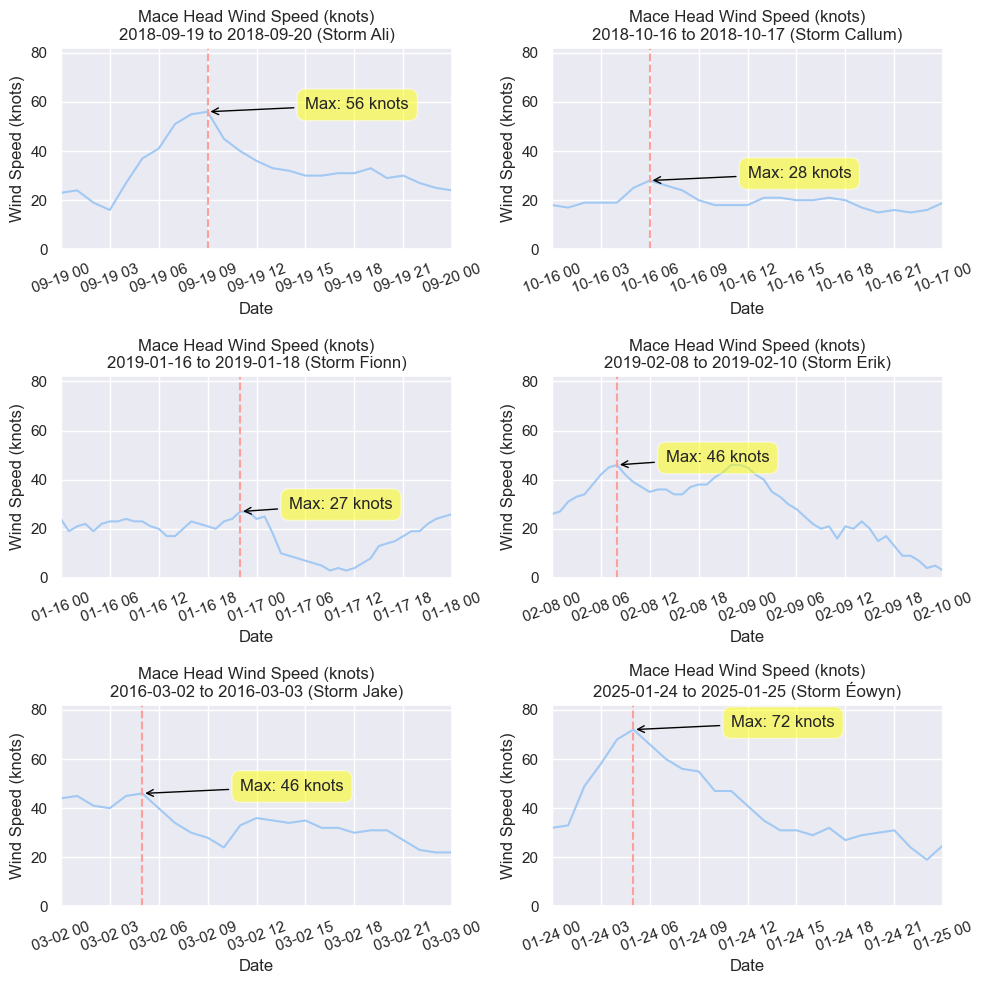

In [7]:
# https://stackoverflow.com/questions/33792478/how-to-suppress-matplotlib-warning
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_theme('notebook', palette='pastel')
# Plot multiple storms in a grid layout
fig, axes = plt.subplots(3, 2, figsize=(10, 10))    
plot_storm(wind_speed, '2018-09-19', '2018-09-20', 'Storm Ali', ax=axes[0, 0])
plot_storm(wind_speed, '2018-10-16', '2018-10-17', 'Storm Callum', ax=axes[0, 1])
plot_storm(wind_speed, '2019-01-16', '2019-01-18', 'Storm Fionn', ax=axes[1, 0])
plot_storm(wind_speed, '2019-02-08', '2019-02-10', 'Storm Erik', ax=axes[1, 1])
plot_storm(wind_speed, '2016-03-02', '2016-03-03', 'Storm Jake', ax=axes[2, 0])
plot_storm(wind_speed, '2025-01-24', '2025-01-25', 'Storm Éowyn', ax=axes[2, 1])
plt.tight_layout()
plt.show()

The wind speeds aren't as incredible as the wikipedia suggested they might be, but this is due to less granular data, being averaged per hour and not detailing things like gust speeds. Nonetheless, this validates the station's ability to capture relevant data. We can now begin to consider wind power at the site.

## Wind Turbines

If we are considering the use of wind turbines in this area we would have to consider the following:

* Minimum wind speed for operation (cut-in): 7-9 mph for power production.
* Rated operation wind speed: 25-55 mph for optimal energy output.
* Shutdown safety measure: Turbine shuts down around 55 mph.

Source: https://twogreenleaves.org/green-living/minimum-maximum-wind-speed-wind-turbine/

1 mile per hour is 0.87 knots.

Source: https://www.unitconverters.net/speed/mph-to-knot.htm

In [8]:
# Convert operating wind speeds from mph to knots
mph_to_knots = 0.8689762419
min_operating_wind_speed_mph = 7
rated_operating_wind_speed_mph = 25
max_operating_wind_speed_mph = 55
min_operating_wind_speed_knots = min_operating_wind_speed_mph * mph_to_knots
rated_operating_wind_speed_knots = rated_operating_wind_speed_mph * mph_to_knots
max_operating_wind_speed_knots = max_operating_wind_speed_mph * mph_to_knots
print(f'Min Operating Wind Speed: {min_operating_wind_speed_knots:.2f} knots')
print(f'Rated Operating Wind Speed: {rated_operating_wind_speed_knots:.2f} knots')
print(f'Max Operating Wind Speed: {max_operating_wind_speed_knots:.2f} knots')

Min Operating Wind Speed: 6.08 knots
Rated Operating Wind Speed: 21.72 knots
Max Operating Wind Speed: 47.79 knots


In [9]:
wind_turbine_viable = wind_speed[
    (wind_speed['wdsp'] >= round(min_operating_wind_speed_knots))
    & (wind_speed['wdsp'] <= round(max_operating_wind_speed_knots))
    ]

print(f'Proportion of time wind turbine can operate:'
      f' {wind_turbine_viable.shape[0]/wind_speed.shape[0]:.2%}')

Proportion of time wind turbine can operate: 89.30%


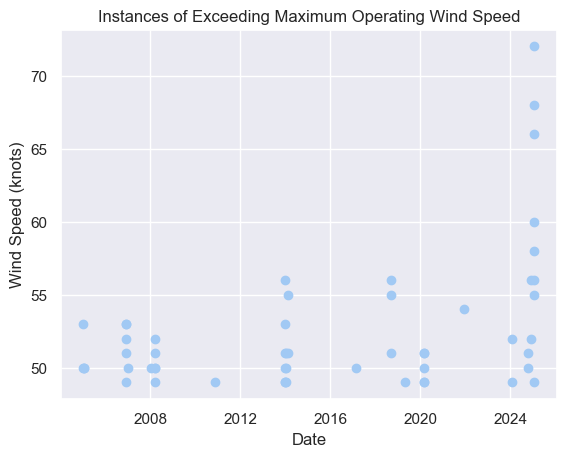

53 instances exceed maximum operating wind speed.
Proportion of total data: 0.03%


In [10]:
exceeding_max_wind_speed = wind_speed[
    wind_speed['wdsp'] > round(max_operating_wind_speed_knots)
    ]
plt.scatter(exceeding_max_wind_speed.index, exceeding_max_wind_speed['wdsp'])
plt.title('Instances of Exceeding Maximum Operating Wind Speed')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.show()
print(f'{exceeding_max_wind_speed.shape[0]} instances exceed maximum operating wind speed.')
exceeding_max_wind_speed_proportion = exceeding_max_wind_speed.shape[0]/wind_speed.shape[0]
print(f'Proportion of total data: {exceeding_max_wind_speed_proportion:.2%}')

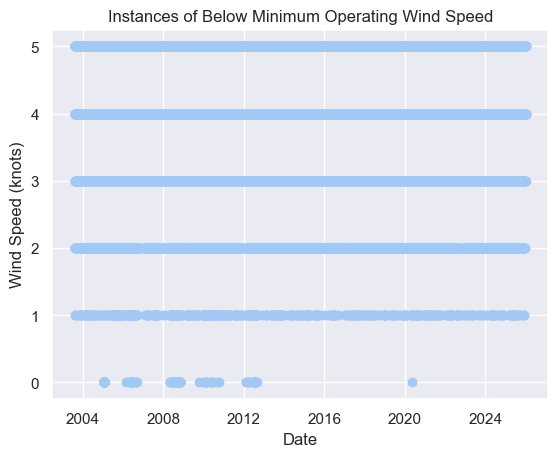

wdsp
5    6609
4    5805
3    4428
2    2609
1     698
0     666
Name: count, dtype: Int64

20815 instances below minimum operating wind speed.
Proportion of total data: 10.68%


In [11]:
under_min_wind_speed = wind_speed[
    wind_speed['wdsp'] < round(min_operating_wind_speed_knots)
    ]
plt.scatter(under_min_wind_speed.index, under_min_wind_speed['wdsp'])
plt.title('Instances of Below Minimum Operating Wind Speed')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.show()
print(under_min_wind_speed['wdsp'].value_counts())
print(f'\n{
    under_min_wind_speed.shape[0]
    } instances below minimum operating wind speed.')
under_min_wind_speed_proportion = (
    under_min_wind_speed.shape[0]/wind_speed.shape[0]
    )
print(f'Proportion of total data: {under_min_wind_speed_proportion:.2%}')

In [12]:
below_rated = wind_speed[
    (wind_speed['wdsp'] >= round(min_operating_wind_speed_knots))
    & (wind_speed['wdsp'] < round(rated_operating_wind_speed_knots))
    ]
below_rated_proportion = (
    below_rated.shape[0]/wind_speed.shape[0]
    )
print(f'Proportion of time below rated operating wind speed:' \
    f' {below_rated_proportion:.2%}')

rated_operation = wind_speed[
    (wind_speed['wdsp'] >= round(rated_operating_wind_speed_knots))
    & (wind_speed['wdsp'] < round(max_operating_wind_speed_knots))
]
rated_proportion = (
    rated_operation.shape[0]/wind_speed.shape[0]
)

print(f'Proportion of time at rated operation: {rated_proportion:.2%}')

Proportion of time below rated operating wind speed: 72.18%
Proportion of time at rated operation: 17.10%


To visualise this distribution we can plot this information on a graph, highlighting the different sections and summing their proportions.

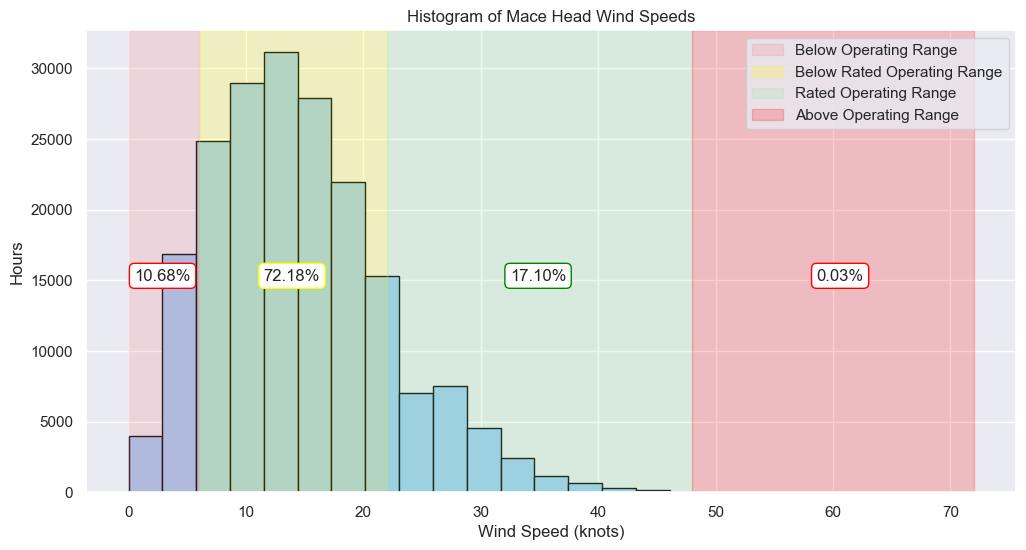

In [13]:
plt.subplots(figsize=(12, 6))
plt.hist(wind_speed['wdsp'], bins=25, edgecolor='black')
plt.title('Histogram of Mace Head Wind Speeds')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Hours')
# https://stackoverflow.com/questions/8270981/how-to-highlight-specific-x-value-ranges
plt.axvspan(xmin=0, xmax=round(min_operating_wind_speed_knots),
            color='lightcoral', alpha=0.2, label='Below Operating Range')
plt.axvspan(xmin=round(min_operating_wind_speed_knots),
             xmax=round(rated_operating_wind_speed_knots),
            color='yellow', alpha=0.2, 
            label='Below Rated Operating Range')
plt.axvspan(xmin=round(rated_operating_wind_speed_knots), 
            xmax=round(max_operating_wind_speed_knots),
            color='lightgreen', alpha=0.2, 
            label='Rated Operating Range')
plt.axvspan(xmin=round(max_operating_wind_speed_knots),
            xmax=wind_speed['wdsp'].max(),
            color='red', alpha=0.2, label='Above Operating Range')
plt.annotate(f'{under_min_wind_speed_proportion:.2%}',
             xy=(0, 15000),
             xytext=(0.5, 15000),
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', lw=1))
plt.annotate(f'{below_rated_proportion:.2%}',
             xy=(min_operating_wind_speed_knots, 15000),
             xytext=((min_operating_wind_speed_knots 
                      + rated_operating_wind_speed_knots*0.25), 15000),
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='yellow', lw=1))
plt.annotate(f'{rated_proportion:.2%}',
             xy=(rated_operating_wind_speed_knots, 15000),
             xytext=((rated_operating_wind_speed_knots
                      + max_operating_wind_speed_knots*0.225), 15000),
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='green', lw=1))
plt.annotate(f'{exceeding_max_wind_speed_proportion:.2%}',
             xy=(max_operating_wind_speed_knots, 15000),
             xytext=((max_operating_wind_speed_knots 
                      + wind_speed['wdsp'].max()*0.15), 15000),
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', lw=1))
plt.legend()

It looks like around 11% of all recorded wind speeds fall below the threshold for electricity production while only 0.03% are above. A wind farm at this location would be operable around 90% of the time. [This source](https://www.tullaghmorewindfarm.ie/faq) says that wind farms are operable around 85% of the time. It would be operating at it's highest capacity 17% of the time but this may vary with the seasons and there may not be as much of a need for power during specific time times.

How does this compare to other potential sites in Ireland?

## National Ratings

We can use the calculations from the previous section to investigate other sites and their capacity for generating wind power.

First we need to import the data from the available CSV files. I will prepare a function that reads in a CSV file and returns the proportion of wind speed recordings that are in the operable range for a wind turbine, between cut-in and shut-down speed, and the proportion of those recordings that are above the rated value for the turbine, where the turbine would be operating at max capacity.

In [14]:
# Function to calculate wind turbine efficiency and peak operating proportion
def calculate_efficiency(file):
    # Convert operating wind speeds from mph to knots
    min_operating_wind_speed_mph = 7
    rated_operating_wind_speed_mph = 25
    max_operating_wind_speed_mph = 55
    mph_to_knots = 0.8689762419
    min_operating_wind_speed_knots = min_operating_wind_speed_mph * mph_to_knots
    rated_operating_wind_speed_knots = rated_operating_wind_speed_mph * mph_to_knots
    max_operating_wind_speed_knots = max_operating_wind_speed_mph * mph_to_knots
    # Read data file
    with open(file, 'r') as f:
        # https://www.geeksforgeeks.org/python/how-to-obtain-the-line-number-in-which-given-word-is-present-using-python/
        # Find the line number where the data starts
        res = next((i for i, line in enumerate(f) if re.match(r'date,ind', line)), None)
    # Read CSV data into DataFrame
    data = pd.read_csv(
        file, parse_dates=['date'], index_col='date', skiprows=res-1,
        low_memory=False, date_format='%d-%b-%Y %H:%M'
        )
    # Clean and process data
    data.replace(to_replace=' ', value=np.nan, inplace=True)
    wind_speed = data.loc[:, ['wdsp']]
    wind_speed.dropna(inplace=True)
    wind_speed['wdsp'] = pd.to_numeric(wind_speed['wdsp'])
    # Calculate efficiency and peak operating proportion
    wind_turbine_operable = wind_speed[
        (wind_speed['wdsp'] >= round(min_operating_wind_speed_knots))
        & (wind_speed['wdsp'] <= round(max_operating_wind_speed_knots))
        ]
    operable = wind_turbine_operable.shape[0]/wind_speed.shape[0]
    rated_operation = wind_speed[
        (wind_speed['wdsp'] >= round(rated_operating_wind_speed_knots))
        & (wind_speed['wdsp'] <= round(max_operating_wind_speed_knots))
        ]
    rated_operation_proportion = rated_operation.shape[0]/wind_speed.shape[0]
    # Return results
    return operable, rated_operation_proportion

Next we need to parse the files for the required information, such as longitude and latitude and the name of each station. We can get this from the first lines of the file using regex and store them in a dictionary along with the efficiency and peak operation figures.

In [15]:
# Initialize dictionary to store wind turbine efficiencies
wind_turbine_proportions = {}

# Loop through data files and calculate efficiencies
for file in os.listdir('data/'):
    if file.endswith('.csv'):
        operable, rated = calculate_efficiency(os.path.join('data/', file))
        with open(os.path.join('data/', file), 'r') as f:
            content = str(f.read())
        # Extract station metadata using regex
        pattern = r'Station Name: (\w+? ?\w+? ?\w+)(\r\n|\r|\n)' \
                  r'Station Height: (\d+) M (\r\n|\r|\n)' \
                  r'Latitude:(-?\d+.\d+)  ,Longitude: (-?\d+.\d+)'
        compiled_pattern = re.compile(pattern)
        results = re.search(compiled_pattern, content)
        # Store results in dictionary
        name = results.group(1).title()
        latitude = results.group(5)
        longitude = results.group(6)
        wind_turbine_proportions[name] = {
            'operable': f'{operable:.2%}',
            'rated operation': f'{rated:.2%}',
            'latitude': latitude,
            'longitude': longitude
            }

We can use the prepared dictionary to plot this information on a map using matplotlib's `Basemap` and annotate it with the caclulated figures.

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
# https://matplotlib.org/stable/gallery/mplot3d/basemap_basics.html
# Define Basemap for Ireland
map = Basemap(projection='lcc', resolution='i',
            lat_0=53.5, lon_0=-8,
            llcrnrlon=-10.75, llcrnrlat=51.25,
            urcrnrlon=-5, urcrnrlat=55.75)
# Draw map features
map.drawmapboundary(fill_color='lightblue', zorder=0)
map.drawcoastlines(linewidth = 0.2, zorder = 1)
map.fillcontinents(color='lightgreen', lake_color='lightblue', zorder=1)
map.drawcountries(linewidth = 0.5, zorder=1)
# Loop through stations and plot efficiencies
for station, info in wind_turbine_proportions.items():
    # https://pythonguides.com/add-text-to-bar-and-scatter-plots-matplotlib/
    # Adjust label positions for specific stations to avoid overlap
    if station == 'Cork Airport':
        x, y = map(float(info['longitude'])-0.55, float(info['latitude']))
    elif station == 'Dublin Airport':
        x, y = map(float(info['longitude'])+0.1, float(info['latitude'])+0.125)
    elif station == 'Dunsany':
        x, y = map(float(info['longitude']), float(info['latitude'])+0.05)
    else:
        x, y = map(float(info['longitude']), float(info['latitude']))
    # Plot station point and label
    map.plot(x, y, marker='o', color='red', markersize=4)
    plt.text(x+2500, y+2500, f'{station}\n{info['operable']}\n{info['rated operation']}',
             fontsize=8, ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
# Set plot title
ax.set_title('Wind Turbine Efficiency at Various Stations in Ireland', pad=20)
# Plot legend for reference
x, y = map(-10.0, 55)
map.plot(x, y, marker='*', color='blue', markersize=12)
plt.text(x+5000, y+5000, 'Name\nOperable\nMax Capacity', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
plt.show()

In [17]:
efficiency_df = pd.DataFrame.from_dict(wind_turbine_proportions, orient='index')
efficiency_df.sort_values('operable', ascending=False).head()

operable rated operation latitude longitude
Malin Head       90.57%          20.39%   55.372    -7.339
Mace Head        89.27%          17.05%   53.326    -9.901
Belmullet        85.05%          11.26%   54.228   -10.007
Sherkin Island   84.65%           9.84%   51.476    -9.428
Cork Airport     80.25%           4.37%   51.847    -8.486

It looks like there is only one location that has better scores than Mace Head and that is Malin Head. There are a number of surprisingly high potential uptime considering their location, including Dublin Airport, but they don't seem to have high value for rated operation.

We can now start to think about the capacity of a wind turbine to produce electricity based on wind speeds.

## Power Generation

From [this source](https://www.engineeringtoolbox.com/wind-power-d_1214.html) we get the calculation for power generation from wind.

$\displaystyle{P = \frac{p A v^3}{2}} = \frac{p \pi d^2 v^3}{8} $

Where:

- $P$ = power ($W$)
- $p$ = density of air ($kg/m^3$)
- $A$ = wind mill area perpendicular to the wind ($m^2$)
- $v$ = wind speed ($m/s$)
- $d$ = wind mill diameter ($m$)

I am taking the density of air from [wikipedia](https://en.wikipedia.org/wiki/Density_of_air) at 15°C.

According to[teagasc.ie](https://teagasc.ie/rural-economy/rural-development/diversification/wind-energy/), a medium sized turbine has a diameter of 48m and is rated 800KW and produces 30% of the theoretical output.

I am taking the conversion of knots to mph as from [unitconverters.net](https://www.unitconverters.net/speed/mph-to-knot.htm).

Plotting this on a graph, we can get the theoretical power output for a wind turbine.

In [18]:
density = 1.2250  # kg/m^3
diameter = 48 # meters
knots_to_mph = 1.150779448
power = (density * (np.pi * (diameter)**2) * ((wind_speed['wdsp']*knots_to_mph)**3)) / 8000  # in kW
plt.subplots(figsize=(8, 6))
plt.plot(wind_speed['wdsp'].sort_values(), power.sort_values(), linewidth=3)
plt.title('Estimated Theoretical Power Output vs Wind Speed')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Power Output (kW)')
plt.xlim(min_operating_wind_speed_knots-2, max_operating_wind_speed_knots+10)
plt.ylim(0, power.max()/2)
plt.axvspan(xmin=0, xmax=round(min_operating_wind_speed_knots),
            color='lightcoral', alpha=0.2, label='Below Operating Range')
plt.axvspan(xmin=round(min_operating_wind_speed_knots),
             xmax=round(rated_operating_wind_speed_knots),
            color='yellow', alpha=0.2, 
            label='Suboptimal Operating Range')
plt.axvspan(xmin=round(rated_operating_wind_speed_knots), 
            xmax=round(max_operating_wind_speed_knots),
            color='lightgreen', alpha=0.2, 
            label='Peak Operating Range')
plt.axvspan(xmin=round(max_operating_wind_speed_knots),
            xmax=wind_speed['wdsp'].max(),
            color='lightcoral', alpha=0.2, label='Above Operating Range')
plt.axvline(x=round(min_operating_wind_speed_knots), 
            color='r', linestyle='--',
            label='Cut-in Wind Speed')
plt.axvline(x=round(rated_operating_wind_speed_knots),
            color='g', linestyle='--',
            label='Rated Wind Speed')
plt.axvline(x=round(max_operating_wind_speed_knots),
            color='b', linestyle='--',
            label='Shut-down Wind Speed')

We can create a function that takes in a wind speed and returns an estimated power output in kilowatts taking into account rated power levels and efficiency. The turbine we are modelling these estimates on has a capacity of 800KW which is about 5% of these estimates so we can apply that as correction factor.

In [19]:
def power_output(ws,
                 min_operating_wind_speed_knots=6.082833692,
                 rated_operating_wind_speed_knots=21.699406048,
                 max_operating_wind_speed_knots=47.843693304,
                 density=1.2250,
                 diameter=48,
                 correction=0.05):
    knots_to_mph = 1.150779448
    if ws < min_operating_wind_speed_knots or ws > max_operating_wind_speed_knots:
        return 0
    elif ws >= rated_operating_wind_speed_knots:
        return (density * (np.pi * diameter**2) * ((rated_operating_wind_speed_knots*knots_to_mph)**3)) / 1000 / 8 * correction
    else:
        return (density * (np.pi * diameter**2) * ((ws*knots_to_mph)**3)) / 1000 / 8 * correction

Let's see what that looks like on a graph.

In [20]:
plt.plot(wind_speed['wdsp'].sort_values(),
         wind_speed['wdsp'].sort_values().apply(power_output),
         color='orange', linestyle='--', linewidth=2,
         label='Power Output Function')
plt.axvspan(xmin=0, xmax=round(min_operating_wind_speed_knots),
            color='lightcoral', alpha=0.2, label='Below Operating Range')
plt.axvspan(xmin=round(min_operating_wind_speed_knots),
             xmax=round(rated_operating_wind_speed_knots),
            color='yellow', alpha=0.2, 
            label='Suboptimal Operating Range')
plt.axvspan(xmin=round(rated_operating_wind_speed_knots), 
            xmax=round(max_operating_wind_speed_knots),
            color='lightgreen', alpha=0.2, 
            label='Peak Operating Range')
plt.axvspan(xmin=round(max_operating_wind_speed_knots),
            xmax=wind_speed['wdsp'].max(),
            color='lightcoral', alpha=0.2, label='Above Operating Range')
plt.xlabel('Wind Speed (knots)')
plt.ylabel('Power Output (kW)')
plt.title('Estimated Power Output vs Wind Speed')

Text(0.5, 1.0, 'Estimated Power Output vs Wind Speed')

We can now use this to look at power generation for a time period.

In [21]:
all_2025_power_output = wind_speed[
    (wind_speed.index.year==2025)
    ]['wdsp'].apply(power_output).sum() / 1000
print(f'{all_2025_power_output:.2f} MWh theoretical output in 2025')
jan_2025_power = wind_speed['wdsp'][
    (wind_speed.index.year==2025) & (wind_speed.index.month==1)
    ].apply(power_output).sum()
print(f'{jan_2025_power / 1000:.2f} MWh in January 2025')

2907.82 MWh theoretical output in 2025
207.64 MWh in January 2025


If we consider that a wind turbine only produces 30% of its theoretical output we can apply this as an additional factor giving us the following estimates:

In [22]:
print(f'{all_2025_power_output*0.30:.2f} MWh at 30% efficiency in 2025')
print(f'{jan_2025_power*0.30 / 1000:.2f} MWh at 30% efficiency in January 2025')

872.35 MWh at 30% efficiency in 2025
62.29 MWh at 30% efficiency in January 2025


We can use this formula to estimate the power production capacity at any given wind speed for a given time period. 

Does wind direction have any effect on this?

### Wind Direction Analysis

In practice, most commercial turbines are fitted with [yaw control systems](https://en.wikipedia.org/wiki/Yaw_system) that allow them to turn into the wind to get better efficiency with varied wind directions but for the purpose of this investigation we will work under the assumption that it is fixed.

If we want to know the most common wind direction we can take the mode of the wind directions.

In [23]:
mode = wind_speed['wddir'].mode()[0]
print(f'Most common wind direction: {mode}°')

Most common wind direction: 280°


If we take wind direction into account we can use the following form of the above formula.

$\displaystyle{P = \frac{p A v^3}{2}}$

Area of ellipse:

$\displaystyle{A_{elispe} = \pi ab}$

Taken from [this geeks for geeks article](https://www.geeksforgeeks.org/maths/ellipse-formula/#area-of-ellipse-formula).

Where:

- $a =$ the minor axis 
- $b =$ the major axis

For a circle $a = b = R$, where $R =$ the radius of the circle. The minor axis will stay constant as the wind moves around a single axis at angle $\theta$ and from [Copilot](https://copilot.microsoft.com/shares/9osVDsDTYGfPwxpUcdSoj) we know that the major axis can be calculated as follows:

$\displaystyle{b = R \cos \theta}$

Calculating A, the area of the mill perpendicular to the wind, as:

$A_{elipse} = \pi R^2 \cos \theta$

[Copilot](https://copilot.microsoft.com/shares/4Dd4whSTNWabH5xBFxDCN) helped me with my logic problem in the next function definition.

In [24]:
def power_output_wddir(wind_direction, wind_speed, diameter=48, mode=280, density=1.2250, unit_adjustment=1.150779448):
    angle_diff = abs((wind_direction - mode + 180) % 360 - 180)
    if angle_diff > 90:
        return 0
    else:
        if np.all(wind_speed < min_operating_wind_speed_knots) or np.all(wind_speed > max_operating_wind_speed_knots):
            return 0
        elif wind_speed >= rated_operating_wind_speed_knots:
            return (density) * (
                np.pi * (diameter/2)**2 * abs(cos(
                    np.radians((wind_direction-mode) % 360))
                )) * ((rated_operating_wind_speed_knots*unit_adjustment)**3) / 2000 * 0.05  # in kW
        else: 
            return (density) * (
                np.pi * (diameter/2)**2 * abs(cos(
                    np.radians((wind_direction-mode) % 360))
                )) * ((wind_speed*unit_adjustment)**3) / 2000 * 0.05  # in kW

wind_speed['power_output'] = wind_speed['wdsp'].apply(power_output)
wind_speed['power_output_wddir'] = wind_speed.apply(
    lambda row: power_output_wddir(row['wddir'], row['wdsp']), axis=1)

We can compare the magnitude of power generation from the two formulae.

In [25]:
total_power_output = wind_speed['power_output'].sum()
total_power_output_wddir = wind_speed['power_output_wddir'].sum()

print(f'Proportion of power output with wind direction consideration: ' \
      f'{total_power_output_wddir / total_power_output:.2%}')

Proportion of power output with wind direction consideration: 53.33%


Let's plot this using the new formula.

In [26]:
# https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html

fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})

x = wind_speed['wdsp'][(wind_speed['wdsp']>min_operating_wind_speed_knots) & (wind_speed['wdsp']<max_operating_wind_speed_knots)]
y = wind_speed['wddir'][(wind_speed['wdsp']>min_operating_wind_speed_knots) & (wind_speed['wdsp']<max_operating_wind_speed_knots)]
z = wind_speed['power_output_wddir'][(wind_speed['wdsp']>min_operating_wind_speed_knots) & (wind_speed['wdsp']<max_operating_wind_speed_knots)]

axes[0, 0].scatter3D(x, y, z)
axes[0, 0].set_zlim(0, z.max())
axes[0, 0].view_init(30)

axes[0, 1].scatter3D(x, y, z)
axes[0, 1].set_zlim(0, z.max())
axes[0, 1].view_init(30, 270)

axes[1, 0].scatter3D(x, y, z)
axes[1, 0].set_zlim(0, z.max())
axes[1, 0].view_init(30, 180)

axes[1, 1].scatter3D(x, y, z)
axes[1, 1].set_zlim(0, z.max())
axes[1, 1].view_init(30, 145)

for ax in axes.flat:
    ax.set_xlabel('Wind Speed (knots)')
    ax.set_ylabel('Wind Direction (°)')
    ax.set_zlabel('Power Output (kW)')

fig.suptitle('Estimated Power Output vs Wind Speed and Direction')

plt.tight_layout()
plt.show()

This [stack overflow question](https://stackoverflow.com/questions/32208359/is-there-a-multi-dimensional-version-of-arange-linspace-in-numpy) helped me get to find a way to plot this as a mesh.

And [this stack overflow question](https://stackoverflow.com/questions/77577613/matplotlib-3d-plot-z-label-cut-off) helped me with a problem where the labels were being cut off.

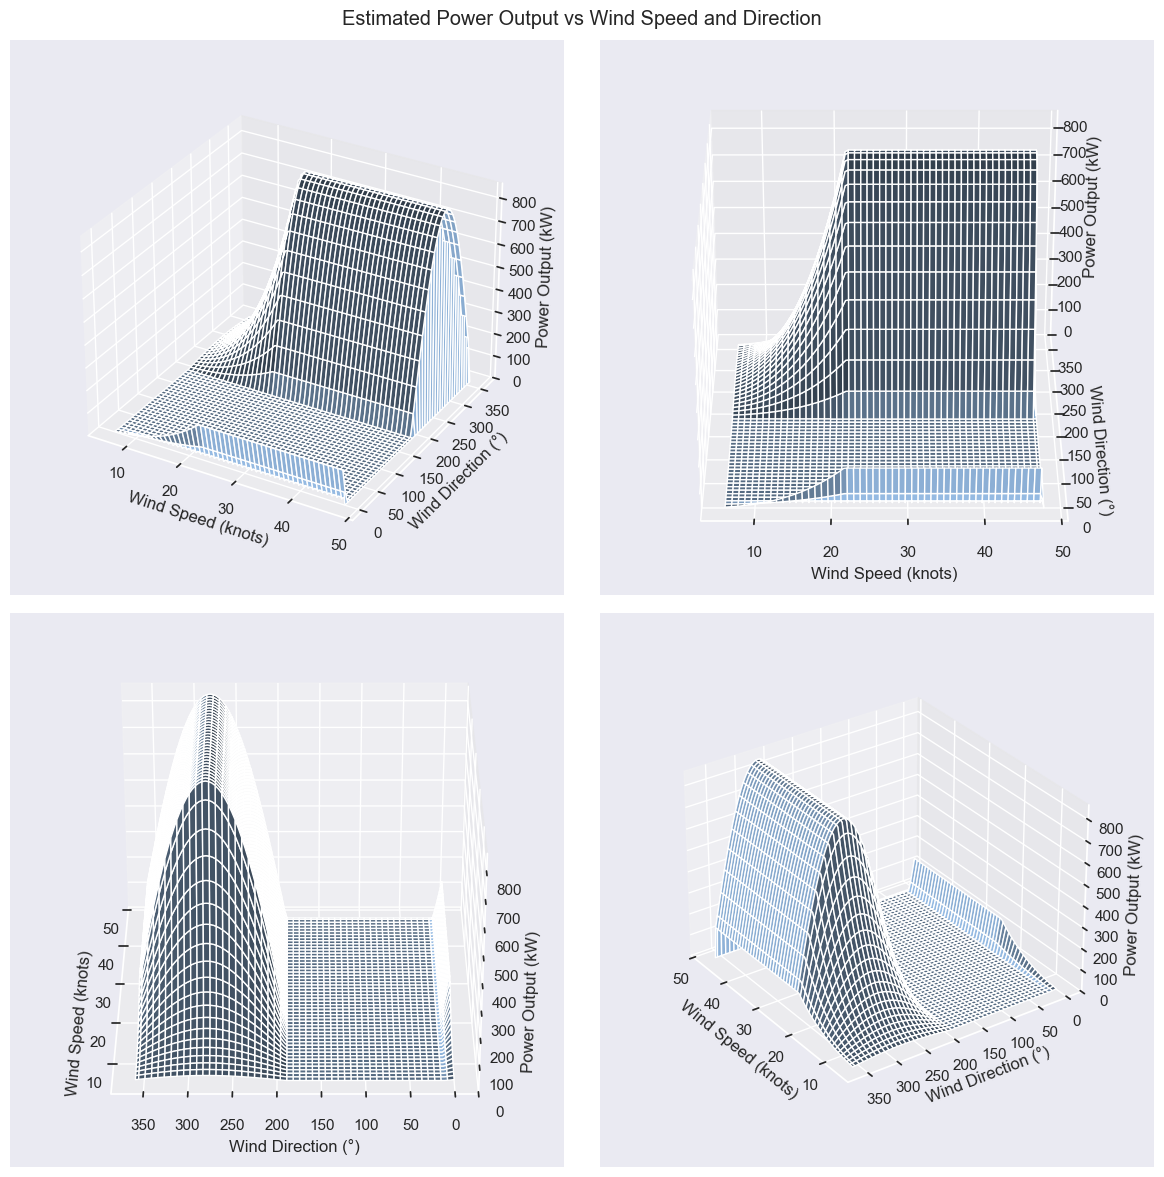

In [27]:
x, y = np.mgrid[min_operating_wind_speed_knots:max_operating_wind_speed_knots:100j, 0:360:100j]
xy = np.vstack([x.ravel(), y.ravel()]).T
z = np.array([power_output_wddir(y, x) for x, y in xy]).reshape(x.shape)

fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})

axes[0, 0].plot_surface(x, y, z)
axes[0, 0].set_zlim(0, z.max())
axes[0, 0].view_init(30)
axes[0, 0].set_box_aspect(None, zoom=0.85)

axes[0, 1].plot_surface(x, y, z)
axes[0, 1].set_zlim(0, z.max())
axes[0, 1].view_init(30, 270)

axes[1, 0].plot_surface(x, y, z)
axes[1, 0].set_zlim(0, z.max())
axes[1, 0].view_init(30, 180)

axes[1, 1].plot_surface(x, y, z)
axes[1, 1].set_zlim(0, z.max())
axes[1, 1].view_init(30, 145)
axes[1, 1].set_box_aspect(None, zoom=0.80)

for ax in axes.flat:
    ax.set_xlabel('Wind Speed (knots)')
    ax.set_ylabel('Wind Direction (°)')
    ax.set_zlabel('Power Output (kW)')

fig.suptitle('Estimated Power Output vs Wind Speed and Direction')

plt.tight_layout()
plt.show()

Let's look at Jan 2025 again.

In [28]:
jan_2025_winddir = wind_speed[
    (wind_speed.index.year==2025) & (wind_speed.index.month==1)
    ]['power_output_wddir'].sum()
print(f'{jan_2025_winddir / 1000:.2f}' \
      f'MWh in January 2025 with wind direction consideration')

76.53MWh in January 2025 with wind direction consideration


Our new formula estimates a power output of 76.5MWh for January 2025, slightly more than our original estimate. A fixed yaw turbine would produce significantly less power than a multi-directional turbine. Perhaps wind direction variability is part of the reason wind turbines often operate at 30% of their total capacity.

For now let's return to wind speed considerations.

## Calculating Monthly Mean Wind Speed

To get an idea of how a wind farm might perform year round we can look at monthly wind speeds.

We can get the monthly average wind speed by resampling the data.

In [29]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
wind_speed_monthly_average = wind_speed['wdsp'].resample('MS').mean()
wind_speed_monthly_average.tail()

date
2025-09-01    17.184722
2025-10-01    17.491935
2025-11-01    15.705556
2025-12-01    16.459677
2026-01-01         13.0
Freq: MS, Name: wdsp, dtype: Float64

One of the most informative plots is a box plot - showing median, quartile ranges and even outliers.

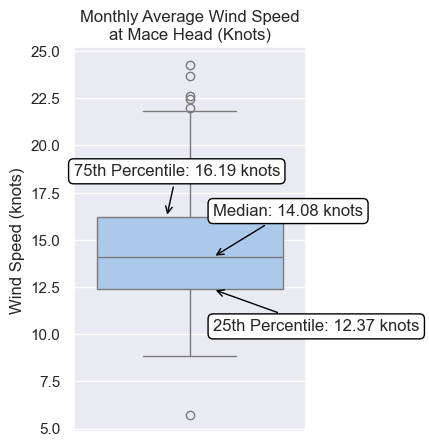

In [30]:
fig, ax = plt.subplots(figsize=(3,5))
boxplot = sns.boxplot(data=wind_speed_monthly_average, ax=ax)
plt.title('Monthly Average Wind Speed\nat Mace Head (Knots)')
plt.ylabel('Wind Speed (knots)')
plt.annotate(f'Median: {wind_speed_monthly_average.median():.2f} knots', 
             xy=(0.1, wind_speed_monthly_average.median()), 
             xytext=(0.1, wind_speed_monthly_average.median()+2.2),
             arrowprops=dict(edgecolor='black', arrowstyle='->'),
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', lw=1))
percentile_25 = wind_speed_monthly_average.quantile(0.25)
plt.annotate(f'25th Percentile: {percentile_25:.2f} knots', 
             xy=(0.1, percentile_25),
             xytext=(0.1, percentile_25-2.2),
             arrowprops=dict(edgecolor='black', arrowstyle='->'),
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', lw=1))
percentile_75 = wind_speed_monthly_average.quantile(0.75)
plt.annotate(f'75th Percentile: {percentile_75:.2f} knots', 
             xy=(-0.1, percentile_75),
             xytext=(-0.5, percentile_75+2.2),
             arrowprops=dict(edgecolor='black', arrowstyle='->'),
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', lw=1))

plt.show()

We can also look at it on a line plot.

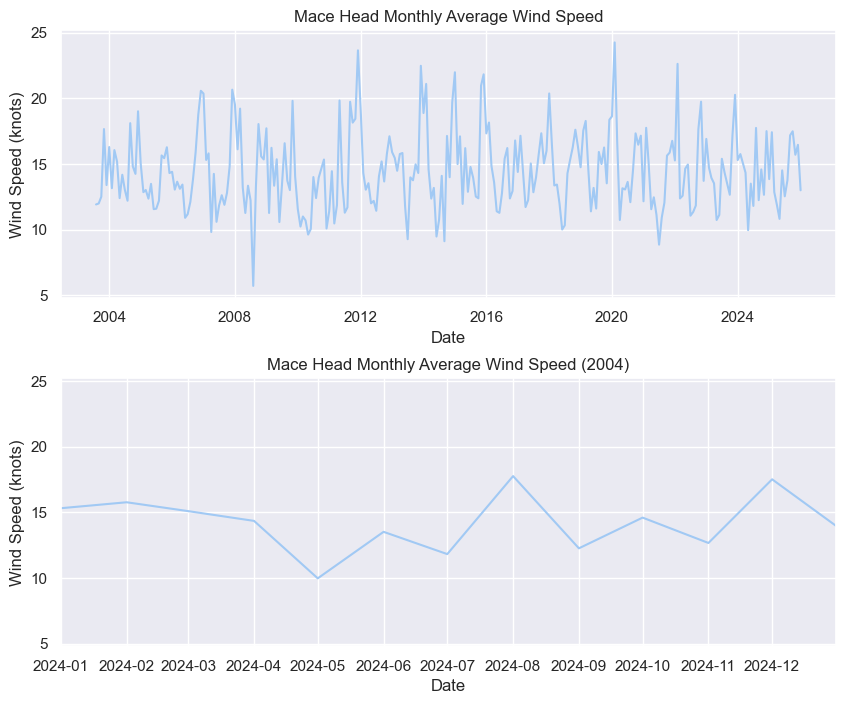

In [31]:
_, axes = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.3)
lineplot = sns.lineplot(data=wind_speed_monthly_average, ax=axes[0])
lineplot.set_title('Mace Head Monthly Average Wind Speed')
lineplot.set_xlabel('Date')
lineplot.set_ylabel('Wind Speed (knots)')
zoom = sns.lineplot(data=wind_speed_monthly_average, ax=axes[1])
zoom.set_title('Mace Head Monthly Average Wind Speed (2004)')
zoom.set_xlabel('Date')
zoom.set_ylabel('Wind Speed (knots)')
zoom.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 12, 31))
plt.show()
plt.close()

We can use relplot to plot the monthly average wind speeds on top of each other and colour them by year to get a better view of the seasonal highs and lows over a year.

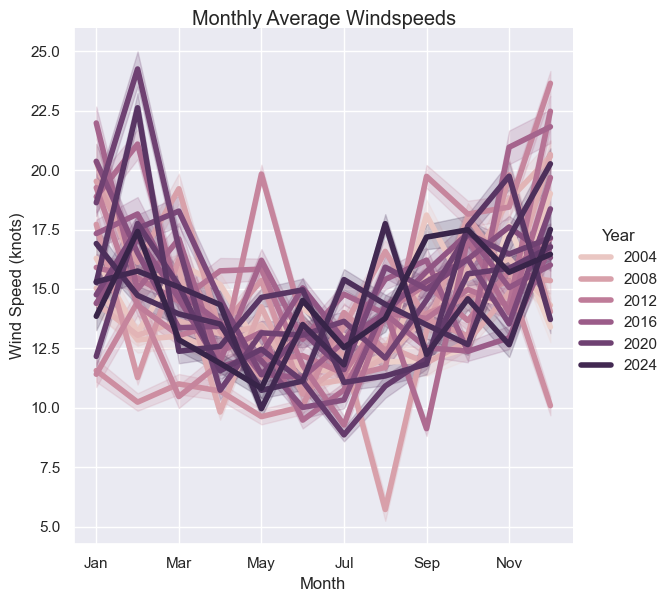

In [32]:
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
          7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

rel = sns.relplot(data=wind_speed, x=wind_speed.index.month, y='wdsp',
                  kind='line', height=6, aspect=1, 
                  hue=wind_speed.index.year, linewidth=4)
rel.figure.suptitle('Monthly Average Windspeeds', y=1)
rel.set_xlabels('Month')
rel.set_ylabels('Wind Speed (knots)')
rel.set(xticks=list(months.keys())[::2],
        xticklabels=list(months.values())[::2])
rel.legend.set_title('Year')
plt.show()
plt.close()

There seems to be a definite seasonal curve to the wind speeds.

We can also view the years individually, with the other years plotted behind them for context.

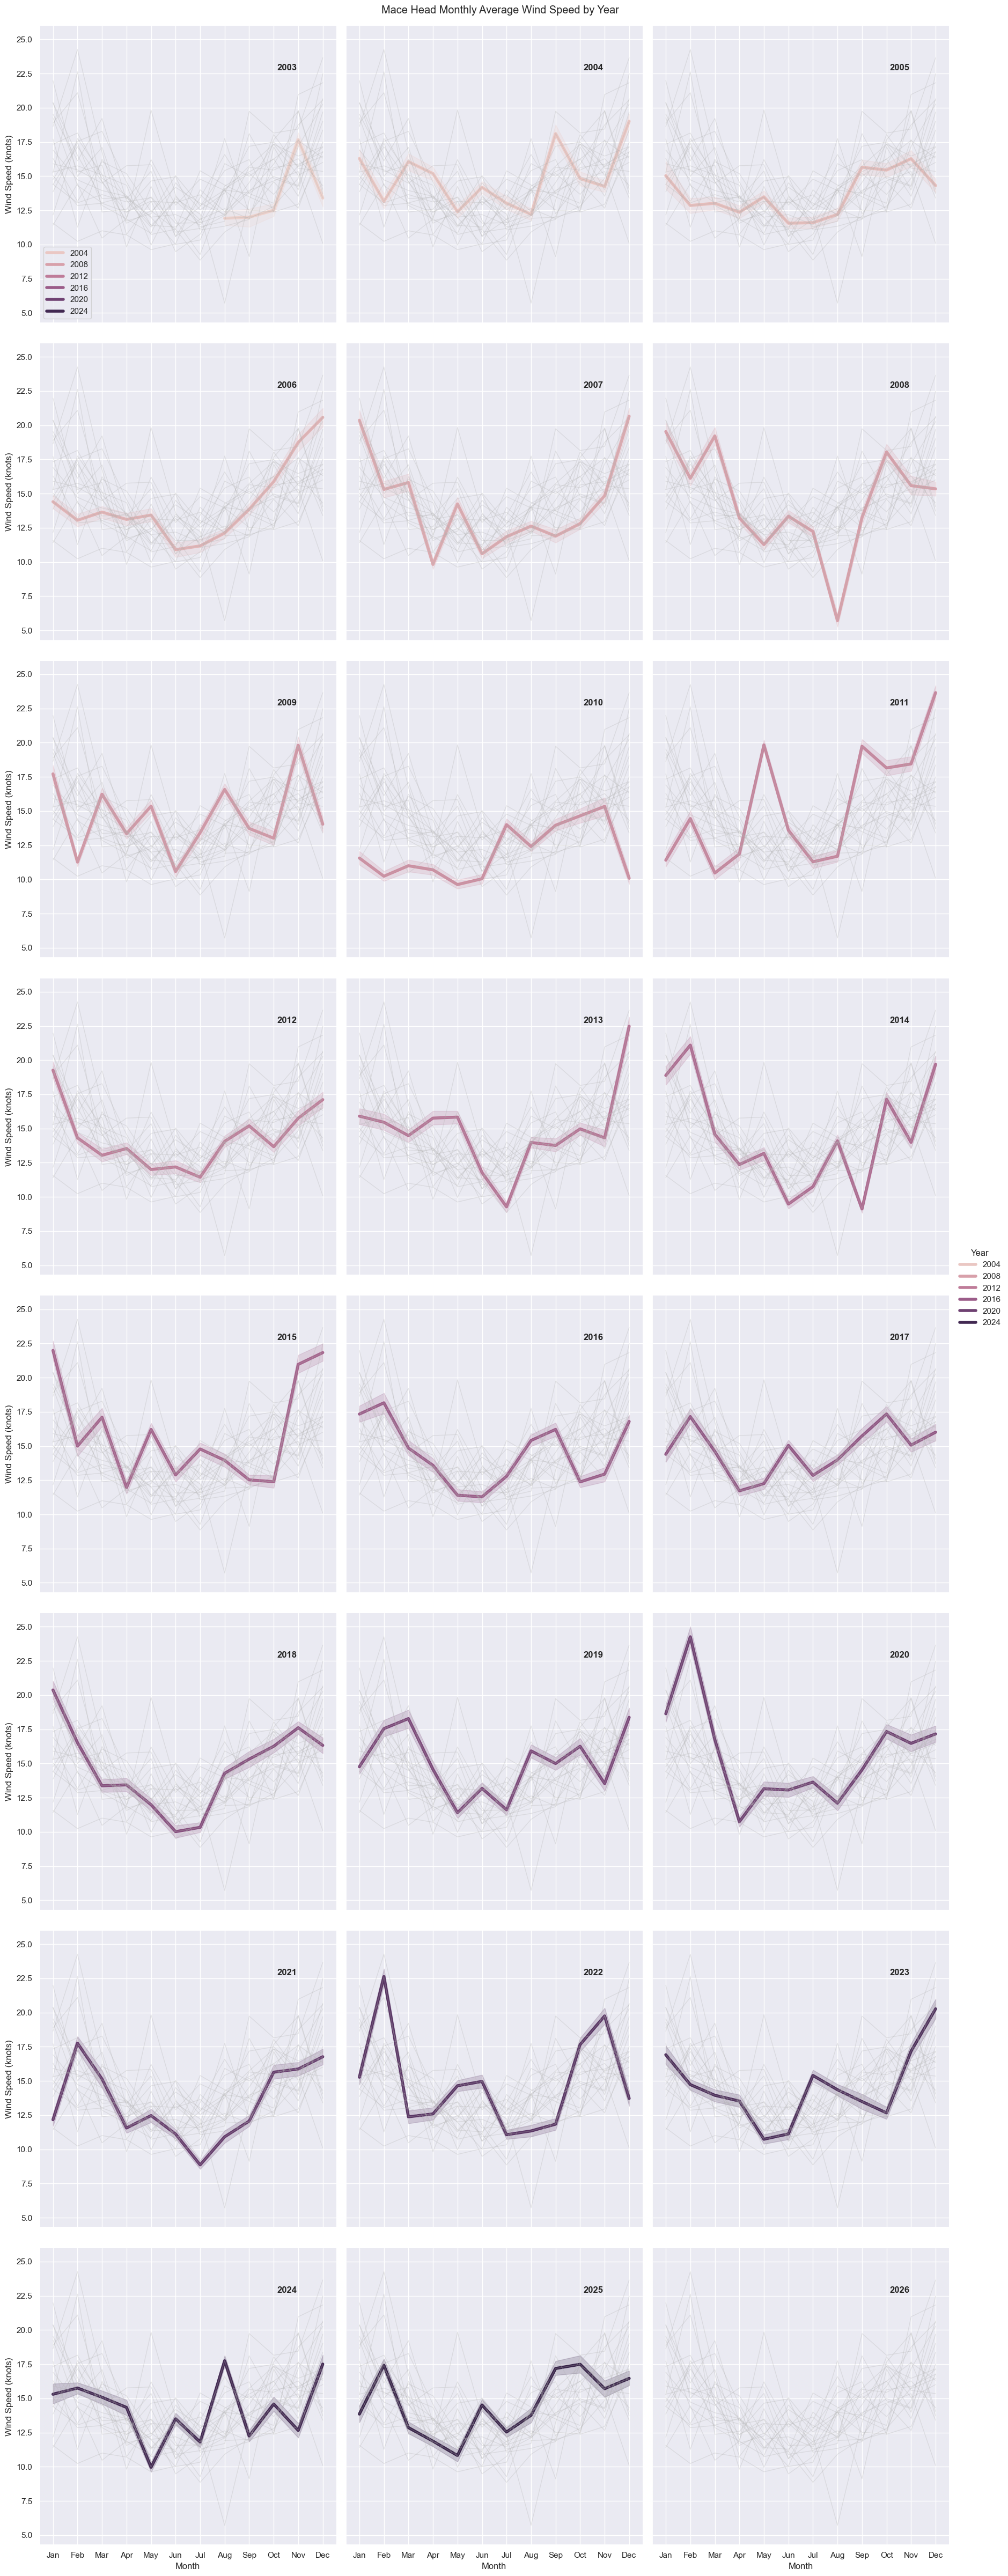

In [33]:
rel = sns.relplot(data=wind_speed, x=wind_speed.index.month, y='wdsp', kind='line',
                   height=6, aspect=1, hue=wind_speed.index.year, 
                   col=wind_speed.index.year, col_wrap=3, linewidth=4)
rel.set_axis_labels('Month', 'Wind Speed (knots)')
rel.set(xticks=list(months.keys()), xticklabels=list(months.values()))
rel.figure.suptitle('Mace Head Monthly Average Wind Speed by Year', y=1)
rel.legend.set_title('Year')

for year, ax in rel.axes_dict.items():
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight='bold')
    ax.title.set_text('')

    sns.lineplot(
        data=pd.DataFrame(wind_speed_monthly_average), 
        x=wind_speed_monthly_average.index.month, y='wdsp', 
        units=wind_speed_monthly_average.index.year,
        estimator=None, color='.7', linewidth=1, ax=ax, alpha=0.3
    )


There seems to be a definite pattern to the data that is not immediately obvious when you look at the years individually, but emerges more clearly when you look at the data together. To get a better idea of how wind speeds change year round we can use machine learning to build models that will allow us to make predictions about the future which are extremely useful in energy planning.

## Machine Learning

In this section I will set about creating a model of my data using ARIMA machine learning models. This will take periodicity into account to give us the general model of average wind speeds by month and make predictions about the future.

I use several guides for this section. They can be found here:

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.geeksforgeeks.org/data-science/model-selection-for-arima/

https://www.datacamp.com/tutorial/arima

### Investigation

The first investigation we can perform is whether or not differencing is required for this dataset.

In [34]:
result = adfuller(wind_speed_monthly_average)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    print('Series is non stationary; differencing is needed.')
else:
    print('Series is stationary; no differencing needed.')

ADF Statistic: -4.178075
p-value: 0.000718
Series is stationary; no differencing needed.


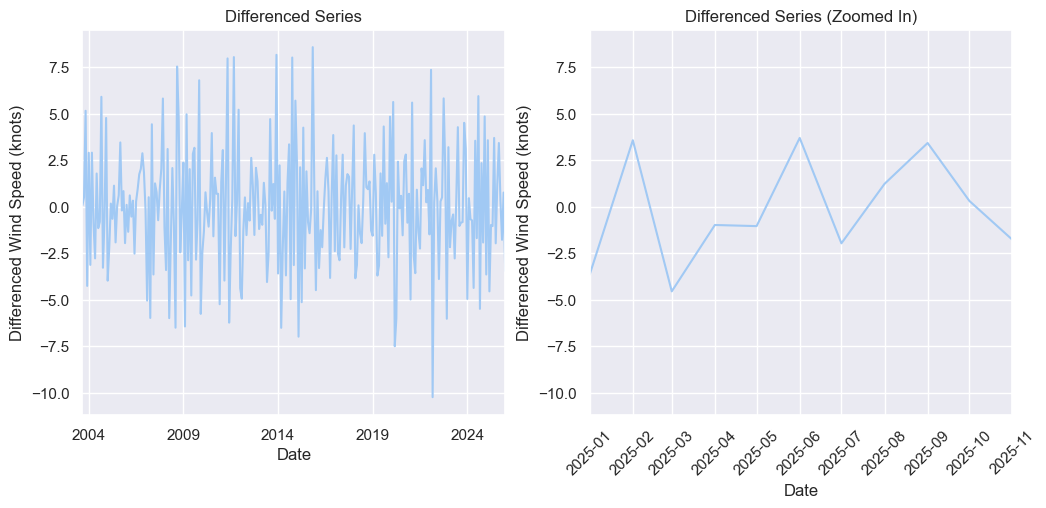

ADF Statistic (differenced): -10.745335
p-value (differenced): 0.000000
Differenced series is stationary; no further differencing needed.


In [35]:
ts_diff = wind_speed_monthly_average.diff().dropna()

fig, axes = plt.subplots(1,2, figsize=(12,5))
ts_diff.plot(title='Differenced Series', ax=axes[0],
             ylabel='Differenced Wind Speed (knots)', xlabel='Date')
line = sns.lineplot(x=ts_diff.index, y=ts_diff.values, ax=axes[1])
axes[1].set_xlim(dt.datetime(2025, 1, 1), dt.datetime(2025, 11, 1))
axes[1].set(title='Differenced Series (Zoomed In)', ylabel='Differenced Wind Speed (knots)',
            xlabel='Date')
axes[1].set_xticklabels(labels=line.get_xticklabels(), rotation=45)
plt.show()

result_diff = adfuller(ts_diff)
print('ADF Statistic (differenced): %f' % result_diff[0])
print('p-value (differenced): %f' % result_diff[1])

if result_diff[1] > 0.05:
    print('Differenced series is non stationary; further differencing may be needed.')
else:
    print('Differenced series is stationary; no further differencing needed.')

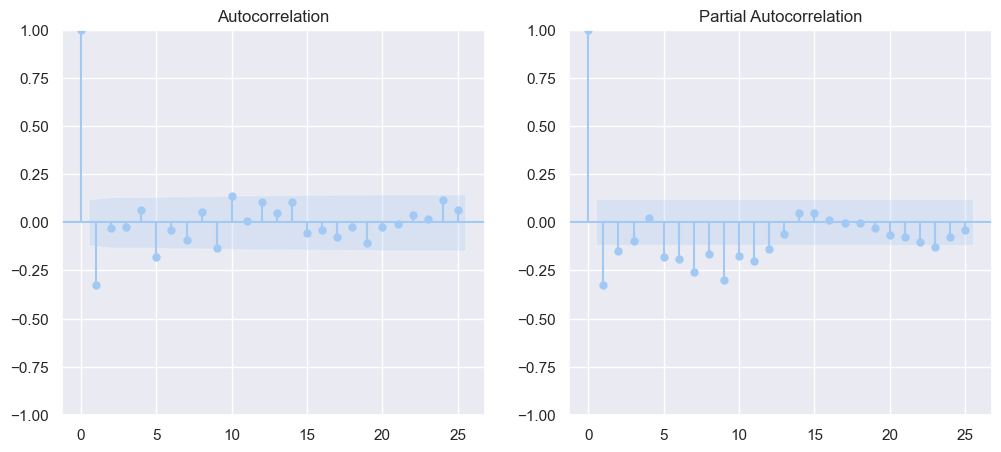

In [36]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

plot_acf(ts_diff, ax=axes[0])
plot_pacf(ts_diff, ax=axes[1])
plt.show()

It looks like no differencing is required according to the AD Fuller tests performed on the data.

### Preprocessing

We first need to separate our data into three separate groups. A training set, a validation set and a test set. These different groups will be used to train our model and evaluate its effectiveness in predicting future values. First we will take 20% of the entire dataset for a test set, then 20% of the remaining data for a validation set.

In [37]:
y = wind_speed_monthly_average
# Establish 20% test size
test_size = 0.2
# Split data into training, validation, and test sets
y_train_full, y_test = train_test_split(y, test_size=test_size,
                                         shuffle=False)
y_train, y_validation = train_test_split(y_train_full,
                                         test_size=test_size, 
                                         shuffle=False)

print(f'Training set from {y_train.index.min().date()} to' \
      f' {y_train.index.max().date()}')
print(f'Validation set from {y_validation.index.min().date()} to' \
      f' {y_validation.index.max().date()}')
print(f'Test set from {y_test.index.min().date()} to' \
      f' {y_test.index.max().date()}')

Training set from 2003-08-01 to 2017-11-01
Validation set from 2017-12-01 to 2021-07-01
Test set from 2021-08-01 to 2026-01-01


### Parameter Tuning

In order to get a good picture of which parameters to use for our model, we can run a series of tests.

There are several parameters for this model.

> The p parameter represents the number of lagged observations included in the autoregressive part of the model. For example, if p=2, the model uses the two most recent time steps (t-1 and t-2) to predict the current value (t). This is useful when past values directly influence future values, such as in stock prices where recent trends might persist. The d parameter determines how many times the data is differenced to remove non-stationarity (e.g., trends or changing variance). If d=1, the model uses the difference between consecutive data points (t and t-1). For instance, if monthly sales data has a linear trend, differencing once can stabilize the mean. The q parameter specifies the number of lagged forecast errors in the moving average component. A q=1 model uses the error from the previous prediction to adjust the current forecast, which helps account for sudden shocks or anomalies in the data, like a spike in website traffic due to a viral event.

[Source](https://blog.milvus.io/ai-quick-reference/what-is-an-arima-pdq-model-and-what-do-the-parameters-represent)

The s parameter is the length of the seasonal period. 

The parameters I will be tuning are P and Q, as our investigation told us that no differencing will be required and we already know that monthly data has a seasonal periodicity of 12.

I have several different methods of determining the best model. I can use root mean squared error (RMSE), mean absolute error (MAE), mean squared error (MSE), mean absolute percentage error (MAPE), the alkaike information criterion (AIC) or the bayesian information criterion (BIC). From [this stack exchange question](https://stats.stackexchange.com/questions/219605/determine-best-arima-model-with-aicc-and-rmse) I learned that the first four are a measure of error and disregard the complexity of the model and optimising for these metrics can give you accurate results, but you run the risk of over fitting the model to the data, especially given how much variation there is in the data year to year. AIC metrics take an error term and add a penalty depending how many predictors were used in the model. This punishes overly complex models in favour of simpler, reasonably accurate accurate models. 

For the purpose of model selection I will use AIC to ensure that I am not over fitting the model to the data. To judge how well the model fits the data, later in the investigation I will be using RMSE.

I was getting a ConvergenceWarning, and upon investigation it was suggested to include a max iterations keyword argument in my `model.fit`. [This stack overflow question](https://stackoverflow.com/questions/52872724/convergencewarning-maximum-likelihood-optimization-failed-to-converge) was helpful to correct the error.

An LU decomposition error was thrown during the grid search, so a combination of [this](https://stackoverflow.com/questions/54136280/sarimax-python-np-linalg-linalg-linalgerror-lu-decomposition-error) and [this](https://stackoverflow.com/questions/72493282/lu-decomposition-error-in-statsmodels-arima-model) stack overflow question led me to implement `enforce_stationarity=False`, `enforce_invertability=False` and `model.initialize_approximate_diffuse()` to ensure it doesn't happen again.

This grid search process can take up to 40 minutes to go through each parameter. Please continue from the next code block to skip this process.

In [38]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# Grid search for best ARIMA parameters
p = range(0, 4)
d = [0]
q = range(0, 4)
s = [(x, 0, z, 12) for x in range(0, 4) for z in range(0, 4)]
pdqs = list(itertools.product(p, d, q, s))

# Initialize variables to store the best results
best_aic = np.inf
best_aic_order = None
history = {}

# Grid search
for order in pdqs:
    try:
        # Fit ARIMA model
        model = ARIMA(
            y_train, order=order[0:3], seasonal_order=order[3],
            trend='ct', freq='MS', enforce_stationarity=False,
            enforce_invertibility=False
            )
        model.initialize_approximate_diffuse()
        results = model.fit(method_kwargs={'maxiter':300})
        # Evaluate AIC and store results
        if results.aic < best_aic:
            best_aic = results.aic
            best_aic_order = order
            history[order] = results.aic

    except Exception as e:
        print(f'Error for order {order}: {e}')

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.from_dict.html
# Print top 10 best AIC results
history_df = pd.DataFrame.from_dict(history, orient='index',
                                    columns=['AIC'])
print(history_df.sort_values(by='AIC').head(10))
print(f'Best ARIMA order: {best_aic_order} AIC: {best_aic:.2f}')

                                 AIC
(2, 0, 3, (0, 0, 3, 12))  652.737417
(2, 0, 2, (0, 0, 3, 12))  655.378370
(0, 0, 3, (2, 0, 3, 12))  658.361304
(0, 0, 3, (1, 0, 3, 12))  659.866801
(0, 0, 2, (2, 0, 3, 12))  662.297230
(0, 0, 2, (1, 0, 3, 12))  664.215359
(0, 0, 1, (2, 0, 3, 12))  664.356557
(0, 0, 1, (1, 0, 3, 12))  666.110139
(0, 0, 1, (0, 0, 3, 12))  674.759120
(0, 0, 0, (2, 0, 3, 12))  676.473778
Best ARIMA order: (2, 0, 3, (0, 0, 3, 12)) AIC: 652.74


The above code can take up to a 40 minutes to run. If you would like to skip the grid search process please continue from here:

In [39]:
# best_aic_order = (2, 0, 3, (0, 0, 3, 12)) # Uncomment this line to fix the best order and skip grid search

### Fitting the model

Using the parameters established in the parameter tuning, we can now build our model and fit our data.

In [40]:
model = ARIMA(y_train, order=best_aic_order[0:3],
              seasonal_order=best_aic_order[3], trend='ct',
              freq='MS')
model_fit = model.fit(method_kwargs={'maxiter':300})
print(model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                             wdsp   No. Observations:                  172
Model:             ARIMA(2, 0, 3)x(0, 0, 3, 12)   Log Likelihood                -399.565
Date:                          Sun, 11 Jan 2026   AIC                            821.131
Time:                                  18:30:42   BIC                            855.753
Sample:                              08-01-2003   HQIC                           835.178
                                   - 11-01-2017                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8458      0.524     26.435      0.000      12.819      14.872
x1             0.0063      0.005      1.232      0.

We can now visualise our model compared to the data in the validation set.

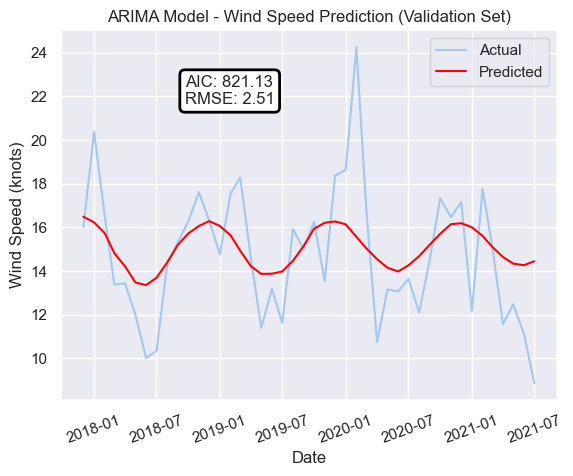

In [41]:
y_hat_validation = model_fit.forecast(steps=len(y_validation))
plt.plot(y_validation.index, y_validation, label='Actual')
plt.plot(y_validation.index, y_hat_validation, label='Predicted',
         color='red')
plt.title('ARIMA Model - Wind Speed Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=20)
plt.annotate(f'AIC: {model_fit.aic:.2f}'\
             f'\nRMSE: {sqrt(mean_squared_error(y_validation, 
                y_hat_validation)):.2f}',
             xy=(0.25, 0.8), xycoords='axes fraction',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', lw=2))
plt.legend()

The metrics look pretty solid. Let's see how this stands up against the test set.

In order to get the best prediction for the test set, we incorporate the data from the validation set and get an updated prediction using the same model trained on more data.

[This geeks for geeks page](https://www.geeksforgeeks.org/python/how-to-change-index-values-in-pandas/) helped me to set the correct index for the predicted values.

In [42]:
model = ARIMA(y_train_full, order=best_aic_order[0:3],
              seasonal_order=best_aic_order[3], trend='ct', freq='MS')
model_fit = model.fit(method_kwargs={'maxiter':300})

y_hat_test = pd.DataFrame(
    model_fit.forecast(steps=len(y_test))).set_index(y_test.index)
plt.plot(y_test, label='Actual Wind Speed')
plt.plot(y_hat_test, color='red', label='Predicted Wind Speed')
plt.title('ARIMA Model - Actual vs Predicted Wind Speed (Test Set)')
plt.xlabel('Time')
plt.xticks(rotation=20)
plt.ylabel('Wind Speed (knots)')
plt.annotate(f'AIC: {model_fit.aic:.2f}\nRMSE:' \
             f' {sqrt(mean_squared_error(y_test, y_hat_test)):.2f}',
             xy=(0.25, 0.85), xycoords=('axes fraction'),
             bbox=dict(boxstyle='round,pad=0.3', fc='white',
             ec='black', lw=2))
plt.legend()
plt.show()

The model seems to fit the test set very well. It even gives us a better RMSE score than our validation set. It captures the periodicity of the data incredibly well. 

Now we can use the entire dataset to model a prediction for the next two years based on our data.

In [43]:
model = ARIMA(y, order=best_aic_order[0:3], seasonal_order=best_aic_order[3], trend='ct', freq='MS')
model_fit = model.fit(method_kwargs={'maxiter':300})

prediction = pd.DataFrame(
                    model_fit.forecast(
                        steps=24
                        )).set_index(
                            pd.date_range(
                                start=y.index.max() + pd.DateOffset(months=1),
                                periods=24, 
                                freq='MS'
                    )
                )
plt.plot(y, label='Historical Wind Speed')
plt.plot(prediction, color='red', label='Forecasted Wind Speed')
plt.title('ARIMA Model - Wind Speed Forecast for Next 24 Months')
plt.xlabel('Date')
plt.ylabel('Wind Speed (knots)')
plt.xticks(rotation=20)
plt.xlim(dt.datetime(2024, 1, 1), dt.datetime(2028, 1, 1))
plt.legend()
plt.annotate(f'AIC: {model_fit.aic:.2f}',
             xy=(0.55, 0.85), xycoords='axes fraction',
             bbox=dict(boxstyle='round,pad=0.3', fc='white',
             ec='black', lw=2))
plt.show()

We can calculate the predicted power output for a selected time period and compare it to the actual data using the previously defined `power_output` function and taking 53% of that estimate. As the real estimate will depend on wind direction as well. To do this we can use the data from the test set.

In [44]:
power_output_from_data = wind_speed[
        (wind_speed.index >= y_hat_test.index.min()) 
        & (wind_speed.index < y_hat_test.index.max())
    ]['wdsp'].apply(power_output).sum() / 1000

print(f'Estimated {power_output_from_data*0.53:.2f} MWh from actual data')

approx_power_output = y_hat_test['predicted_mean'].apply(power_output).sum() * 24 * 30 / 1000
print(f'Estimated {approx_power_output*0.53:.2f} MWh predicted from July 2021 to Dec 2025')

print(f'\nEstimated {(power_output_from_data - approx_power_output)*0.53:.2f} MWh difference between actual and predicted')
print(f'Estimated {(power_output_from_data - approx_power_output) / (power_output_from_data + approx_power_output):.2%} difference')


Estimated 6830.30 MWh from actual data
Estimated 6366.10 MWh predicted from July 2021 to Dec 2025

Estimated 464.20 MWh difference between actual and predicted
Estimated 3.52% difference


These values are extremely close. Only a 3.5% difference between our prediction and the value generated from data on testing. This number will change as data is updated.

We can now make predictions about the future using the predictions from this model.

In [45]:
predicted_power = prediction['predicted_mean'].apply(power_output) * 0.53
total_predicted_energy_mwh = predicted_power.sum() * 24 * 30 / 1000
print(f'Total predicted energy output over next 24 months: {total_predicted_energy_mwh:.2f} MWh')
print(f'Predicted energy output for January 2026: {predicted_power.iloc[0] * 30 * 24 / 1000:.2f} MWh')


Total predicted energy output over next 24 months: 2563.37 MWh
Predicted energy output for January 2026: 123.17 MWh


## Predicting Power Generation Based on Forecasts

Another way we can make predictions about future power generation is to use an api to get wind speed forecasts for the coming week.

This example code was taken from the [Open-Meteo website](https://open-meteo.com/en/docs?hourly=wind_speed_10m&latitude=53.326&longitude=-9.901&wind_speed_unit=kn).

In [46]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = 'https://api.open-meteo.com/v1/forecast'
params = {
	'latitude': 53.326,
	'longitude': -9.901,
	'hourly': ['wind_speed_10m', 'wind_direction_10m'],
	'wind_speed_unit': 'kn',
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f'Coordinates: {response.Latitude()}°N {response.Longitude()}°E')
print(f'Elevation: {response.Elevation()} m asl')
print(f'Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s')

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_wind_speed_10m = hourly.Variables(0).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {'date': pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = 's', utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = 's', utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = 'left'
)}

hourly_data['wind_speed_10m'] = hourly_wind_speed_10m
hourly_data['wind_direction_10m'] = hourly_wind_direction_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print('\nHourly data\n', hourly_dataframe)


Coordinates: 53.32075881958008°N -9.888671875°E
Elevation: 15.0 m asl
Timezone difference to GMT+0: 0s

Hourly data
                          date  wind_speed_10m  wind_direction_10m
0   2026-01-11 00:00:00+00:00       25.269920          187.000000
1   2026-01-11 01:00:00+00:00       26.241840          187.000000
2   2026-01-11 02:00:00+00:00       25.464306          188.000000
3   2026-01-11 03:00:00+00:00       22.742928          185.000000
4   2026-01-11 04:00:00+00:00       20.410320          182.000000
..                        ...             ...                 ...
163 2026-01-17 19:00:00+00:00        4.460255          281.309906
164 2026-01-17 20:00:00+00:00        4.577320          266.347839
165 2026-01-17 21:00:00+00:00        5.102349          252.255234
166 2026-01-17 22:00:00+00:00        6.003918          240.945480
167 2026-01-17 23:00:00+00:00        7.043571          230.599365

[168 rows x 3 columns]


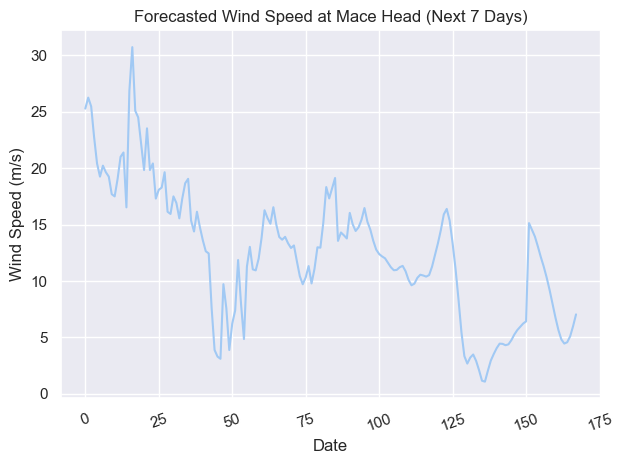

In [47]:
plt.plot(hourly_dataframe.index, hourly_dataframe['wind_speed_10m'])
plt.title('Forecasted Wind Speed at Mace Head (Next 7 Days)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

We can now use our formulae from previous sections to make predictions about the power production for the next week. We can use corrections based on the differences between the predictions made by the two formulae on data from 2025 in the same month to correct for the difference between the formulae. 

In [48]:
forecasted_power_output = hourly_dataframe.apply(
    lambda row:
      power_output_wddir(
          row['wind_direction_10m'],
          row['wind_speed_10m']
          ), axis=1).sum() / 1000

month = hourly_dataframe['date'].min().month
estimated_power_output_month = wind_speed[
    (wind_speed.index.year==2025) & (wind_speed.index.month==month)
    ]['power_output_wddir'].sum()
estimated_power_output_month_wddir = wind_speed[
    (wind_speed.index.year==2025) & (wind_speed.index.month==month)
    ]['power_output'].sum()

correction_factor = estimated_power_output_month / estimated_power_output_month_wddir

arima_power_output = predicted_power.iloc[0] * 30 * 24 / 1000 * (7 / 30) * correction_factor

print(f'{forecasted_power_output:.2f}' \
       f' MWh predicted power output for week ahead from Open-Meteo data')
print(f'{arima_power_output:.2f}' \
      f' MWh for a week in {months[month]} based on ARIMA model')
difference = abs(arima_power_output - forecasted_power_output)
print(f'Difference in estimates: ' \
      f'{difference:.2f} MWh')
proportion = min(
       forecasted_power_output, arima_power_output
       ) / max(
       forecasted_power_output, arima_power_output
       )
print(f'Percentage difference in estimates: ' \
      f'{1 - proportion:.2%}')

16.27 MWh predicted power output for week ahead from Open-Meteo data
10.59 MWh for a week in Jan based on ARIMA model
Difference in estimates: 5.68 MWh
Percentage difference in estimates: 34.91%


As of 10th January 2026, these estimates are extremely close. Within 3% of each other.

As of 11th January, there is a 35% difference between the estimates.

## Conclusion

The evidence collected would suggest that Mace Head would make an excellent candidate for a wind farm location.

### Evidence

- Potential uptime of 90%.

- Ranks highly against other weather stations around Ireland.

- Estimated generation: 75+ MWh per month from a single turbine.

- 20+ years of continuous data collection enables reliable prediction and planning

### Predictive Capability

The ARIMA model developed in this analysis has made predictions within 3.5% of historical data using the formulae developed in this analysis. The difference between the estimates from forecasts and the model range between 3% and 35%. This predictive capability would be extremely useful for any energy planning for the site.

### Next Steps

- Compare theoretical output calculations to figures from working wind turbines and improve estimation calculations

- Keep a record of weather forecasts in the area and compare forecasted and predicted wind speeds to verify findings. 

- Improve and refine existing models with new data as it is recorded.

- Carry out environmental impact studies to verify the location as a potential site for a wind farm.

- Launch investigations into other sites recognised in this analysis.

**Summary**: Mace Head Atmospheric Research Station's extensive data collection has helped develop models and estimations that provide sufficient evidence to indicate the location as a key site for the expansion of Ireland's growing development of renewable energy production.

# End